# Step #1 Load the Data

In [1]:
# Time Series Forecasting - Multi-output Regression for Stock Market Prediction
# A tutorial for this file is available at www.relataly.com

import math # Mathematical functions 
import numpy as np # Fundamental package for scientific computing with Python
import pandas as pd # Additional functions for analysing and manipulating data
from datetime import date, timedelta, datetime # Date Functions
from pandas.plotting import register_matplotlib_converters # This function adds plotting functions for calender dates
import matplotlib.pyplot as plt # Important package for visualization - we use this to plot the market data
import matplotlib.dates as mdates # Formatting dates
import tensorflow as tf
from sklearn.metrics import mean_absolute_error, mean_squared_error # Packages for measuring model performance / errors
from tensorflow.keras.models import Sequential # Deep learning library, used for neural networks
from tensorflow.keras.layers import LSTM, Dense, Dropout # Deep learning classes for recurrent and regular densely-connected layers
from tensorflow.keras.callbacks import EarlyStopping # EarlyStopping during model training
from sklearn.preprocessing import RobustScaler, MinMaxScaler # This Scaler removes the median and scales the data according to the quantile range to normalize the price data 
import seaborn as sns
sns.set_style('white', { 'axes.spines.right': False, 'axes.spines.top': False})

# check the tensorflow version and the number of available GPUs
print('Tensorflow Version: ' + tf.__version__)
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))

# from pandas_datareader.nasdaq_trader import get_nasdaq_symbols
# symbols = get_nasdaq_symbols()

# Setting the timeframe for the data extraction
end_date =  date.today().strftime("%Y-%m-%d")
start_date = '2010-01-01'

# Getting NASDAQ quotes
stockname = 'Apple'
symbol = 'AAPL'
# df = webreader.DataReader(
#     symbol, start=start_date, end=end_date, data_source="yahoo"
# )

import yfinance as yf #Alternative package if webreader does not work: pip install yfinance
df = yf.download(symbol, start=start_date, end=end_date)

# # Create a quick overview of the dataset
df.head()

Tensorflow Version: 2.6.0
Num GPUs: 1
[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,7.622500,7.660714,7.585000,7.643214,6.515213,493729600
2010-01-05,7.664286,7.699643,7.616071,7.656429,6.526477,601904800
2010-01-06,7.656429,7.686786,7.526786,7.534643,6.422666,552160000
2010-01-07,7.562500,7.571429,7.466071,7.520714,6.410791,477131200
2010-01-08,7.510714,7.571429,7.466429,7.570714,6.453413,447610800


# Step #2 Exploring the Data

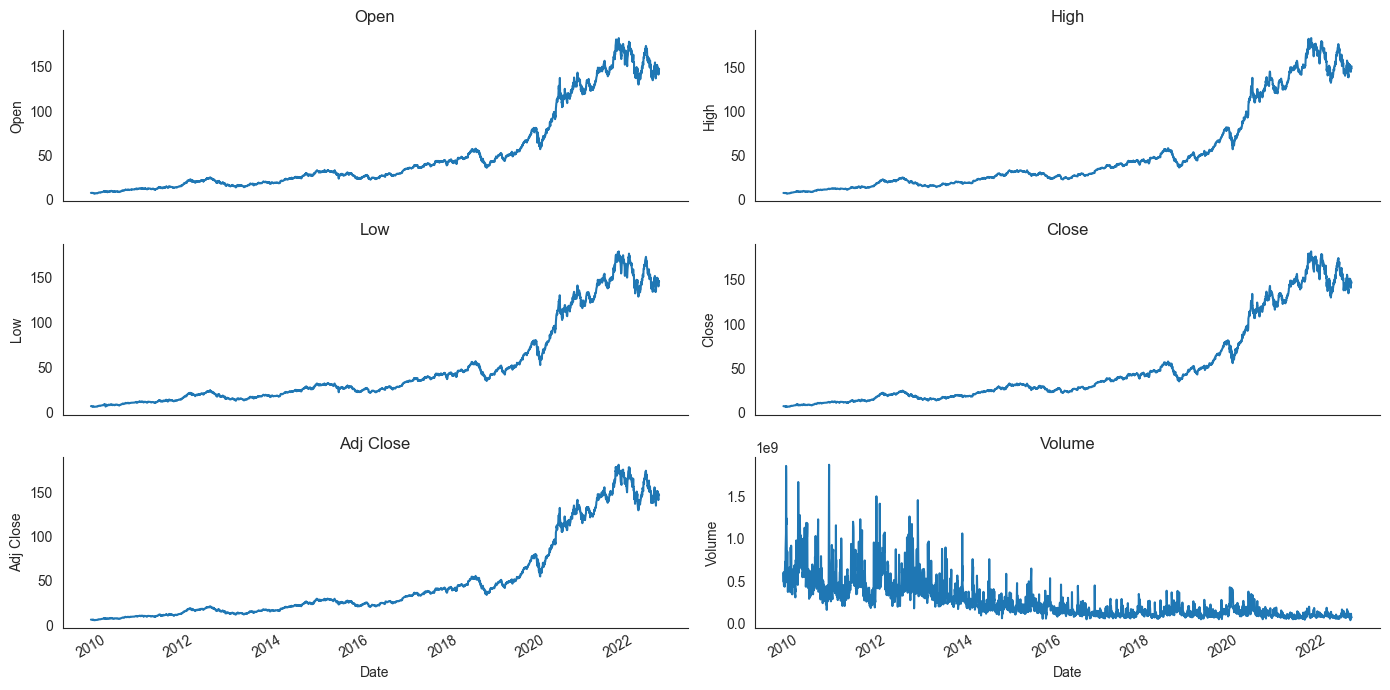

In [2]:
# Plot line charts
df_plot = df.copy()

ncols = 2
nrows = int(round(df_plot.shape[1] / ncols, 0))

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, figsize=(14, 7))
for i, ax in enumerate(fig.axes):
        sns.lineplot(data = df_plot.iloc[:, i], ax=ax)
        ax.tick_params(axis="x", rotation=30, labelsize=10, length=0)
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())
        ax.title.set_text(df_plot.columns[i])
fig.tight_layout()
plt.show()

# Step #3 Preprocessing and Feature Selection

In [3]:
# Indexing Batches
df_train = df.sort_values(by=['Date']).copy()
df_train.tail(5)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-11-29,144.289993,144.809998,140.350006,141.169998,141.169998,83763800
2022-11-30,141.399994,148.720001,140.550003,148.029999,148.029999,111224400
2022-12-01,148.210007,149.130005,146.610001,148.309998,148.309998,71250400
2022-12-02,145.960007,148.000000,145.649994,147.809998,147.809998,65421400
2022-12-05,147.770004,150.919998,145.770004,146.630005,146.630005,68732400


In [29]:
def prepare_data(df):

    # List of considered Features
    FEATURES = ['Open', 'High', 'Low', 'Close', 'Volume']

    print('FEATURE LIST')
    print([f for f in FEATURES])

    # Create the dataset with features and filter the data to the list of FEATURES
    df_filter = df[FEATURES]
    
    # Convert the data to numpy values
    np_filter_unscaled = np.array(df_filter)
    #np_filter_unscaled = np.reshape(np_unscaled, (df_filter.shape[0], -1))
    print(np_filter_unscaled.shape)

    np_c_unscaled = np.array(df['Close']).reshape(-1, 1)
    
    return np_filter_unscaled, np_c_unscaled, df_filter
    
np_filter_unscaled, np_c_unscaled, df_filter = prepare_data(df_train)
                                          
# Creating a separate scaler that works on a single column for scaling predictions
# Scale each feature to a range between 0 and 1
scaler_train = MinMaxScaler()
np_scaled = scaler_train.fit_transform(np_filter_unscaled)
    
# Create a separate scaler for a single column
scaler_pred = MinMaxScaler()
np_scaled_c = scaler_pred.fit_transform(np_c_unscaled)   

FEATURE LIST
['Open', 'High', 'Low', 'Close', 'Volume']
(3254, 5)


In [28]:
df_train

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,7.622500,7.660714,7.585000,7.643214,6.515213,493729600
2010-01-05,7.664286,7.699643,7.616071,7.656429,6.526477,601904800
2010-01-06,7.656429,7.686786,7.526786,7.534643,6.422666,552160000
2010-01-07,7.562500,7.571429,7.466071,7.520714,6.410791,477131200
2010-01-08,7.510714,7.571429,7.466429,7.570714,6.453413,447610800
...,...,...,...,...,...,...
2022-11-29,144.289993,144.809998,140.350006,141.169998,141.169998,83763800
2022-11-30,141.399994,148.720001,140.550003,148.029999,148.029999,111224400
2022-12-01,148.210007,149.130005,146.610001,148.309998,148.309998,71250400


(2544, 50, 5) (2544, 10)
(640, 50, 5) (640, 10)


<function matplotlib.pyplot.show(close=None, block=None)>

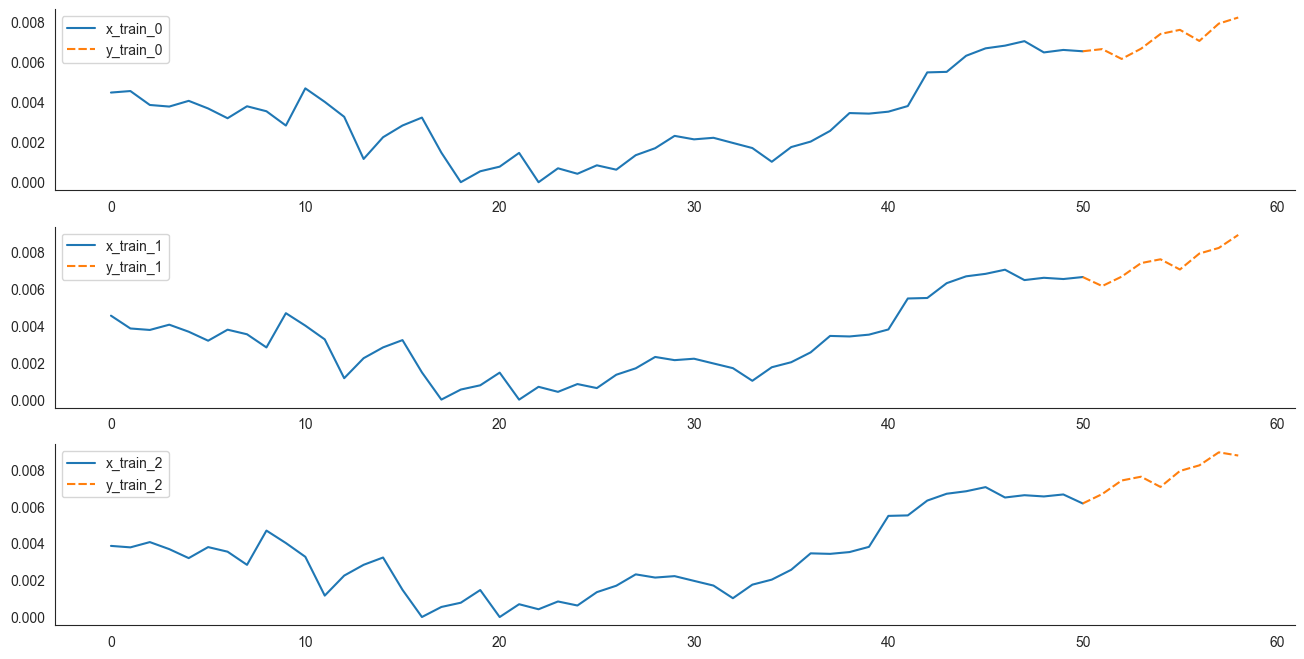

In [30]:
# Set the input_sequence_length length - this is the timeframe used to make a single prediction
input_sequence_length = 50
# The output sequence length is the number of steps that the neural network predicts
output_sequence_length = 10 #

# Prediction Index
index_Close = df_filter.columns.get_loc("Close")

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_length = math.ceil(np_scaled.shape[0] * 0.8)

# Create the training and test data
train_data = np_scaled[:train_data_length, :]
test_data = np_scaled[train_data_length - input_sequence_length:, :]

# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, input_sequence_length time steps per sample, and f features
def partition_dataset(input_sequence_length, output_sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(input_sequence_length, data_len - output_sequence_length):
        x.append(data[i-input_sequence_length:i,:]) #contains input_sequence_length values 0-input_sequence_length * columns
        y.append(data[i:i + output_sequence_length, index_Close]) #contains the prediction values for validation (3rd column = Close),  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(input_sequence_length, output_sequence_length, train_data)
x_test, y_test = partition_dataset(input_sequence_length, output_sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
nrows = 3 # number of shifted plots
fig, ax = plt.subplots(nrows=nrows, ncols=1, figsize=(16, 8))
for i, ax in enumerate(fig.axes):
    xtrain = pd.DataFrame(x_train[i][:,index_Close], columns={f'x_train_{i}'})
    ytrain = pd.DataFrame(y_train[i][:output_sequence_length-1], columns={f'y_train_{i}'})
    ytrain.index = np.arange(input_sequence_length, input_sequence_length + output_sequence_length-1)
    xtrain_ = pd.concat([xtrain, ytrain[:1].rename(columns={ytrain.columns[0]:xtrain.columns[0]})])
    df_merge = pd.concat([xtrain_, ytrain])
    sns.lineplot(data = df_merge, ax=ax)
plt.show

# Step #4 Model Training

In [6]:
# Configure the neural network model
model = Sequential()
n_output_neurons = output_sequence_length

# Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
n_input_neurons = x_train.shape[1] * x_train.shape[2]
print(n_input_neurons, x_train.shape[1], x_train.shape[2])
model.add(LSTM(n_input_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
model.add(LSTM(n_input_neurons, return_sequences=False))
model.add(Dense(5))
model.add(Dense(n_output_neurons))

# Compile the model
model.compile(optimizer='adam', loss='mse')

250 50 5


In [7]:
# Training the model
epochs = 5
batch_size = 16
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test)
                   )
                    
                    #callbacks=[early_stop])

Epoch 1/5
159/159 [==============================] - 7s 14ms/step - loss: 0.0047 - val_loss: 0.0262
Epoch 2/5
159/159 [==============================] - 2s 11ms/step - loss: 3.6759e-04 - val_loss: 0.0097
Epoch 3/5
159/159 [==============================] - 2s 11ms/step - loss: 1.5222e-04 - val_loss: 0.0056
Epoch 4/5
159/159 [==============================] - 2s 11ms/step - loss: 1.0327e-04 - val_loss: 0.0031
Epoch 5/5
159/159 [==============================] - 2s 11ms/step - loss: 1.1690e-04 - val_loss: 0.0026


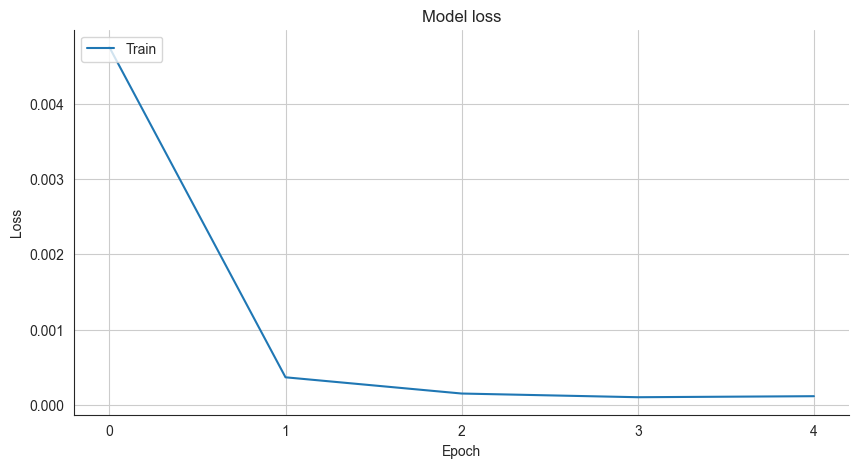

In [8]:
# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(10, 5), sharex=True)
plt.plot(history.history["loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.legend(["Train"], loc="upper left")
plt.grid()
plt.show()

# Step #5 Evaluate Model Performance

Median Absolute Error (MAE): 7.06
Mean Absolute Percentage Error (MAPE): 4.94 %
Median Absolute Percentage Error (MDAPE): 4.36 %


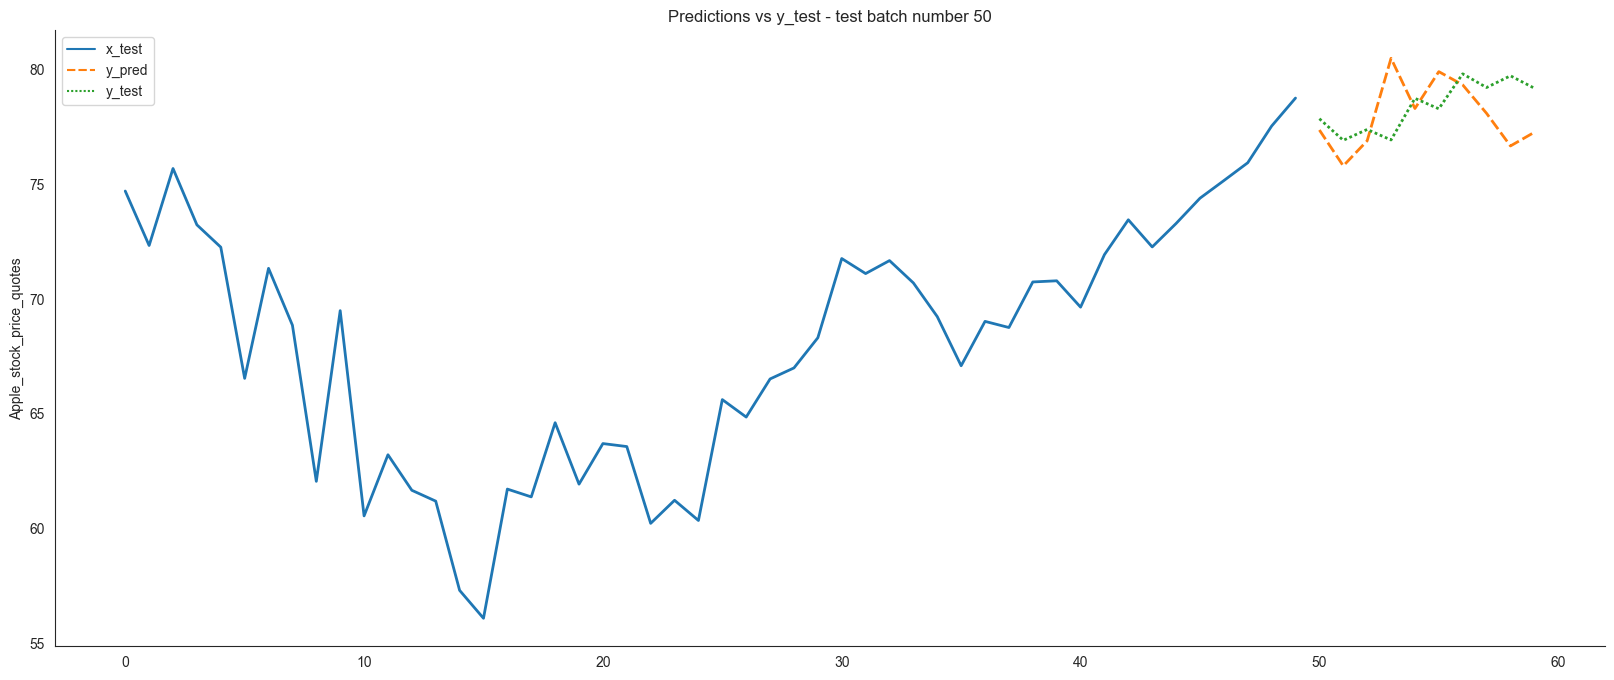

In [31]:
# Get the predicted values
y_pred_scaled = model.predict(x_test)

# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test).reshape(-1, output_sequence_length)

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')


def prepare_df(i, x, y, y_pred_unscaled):
    # Undo the scaling on x, reshape the testset into a one-dimensional array, so that it fits to the pred scaler
    x_test_unscaled_df = pd.DataFrame(scaler_pred.inverse_transform((x[i]))[:,index_Close]).rename(columns={0:'x_test'})
    
    y_test_unscaled_df = []
    # Undo the scaling on y
    if type(y) == np.ndarray:
        y_test_unscaled_df = pd.DataFrame(scaler_pred.inverse_transform(y)[i]).rename(columns={0:'y_test'})

    # Create a dataframe for the y_pred at position i, y_pred is already unscaled
    y_pred_df = pd.DataFrame(y_pred_unscaled[i]).rename(columns={0:'y_pred'})
    return x_test_unscaled_df, y_pred_df, y_test_unscaled_df


def plot_multi_test_forecast(x_test_unscaled_df, y_test_unscaled_df, y_pred_df, title): 
    # Package y_pred_unscaled and y_test_unscaled into a dataframe with columns pred and true   
    if type(y_test_unscaled_df) == pd.core.frame.DataFrame:
        df_merge = y_pred_df.join(y_test_unscaled_df, how='left')
    else:
        df_merge = y_pred_df.copy()
    
    # Merge the dataframes 
    df_merge_ = pd.concat([x_test_unscaled_df, df_merge]).reset_index(drop=True)
    
    # Plot the linecharts
    fig, ax = plt.subplots(figsize=(20, 8))
    plt.title(title, fontsize=12)
    ax.set(ylabel = stockname + "_stock_price_quotes")
    sns.lineplot(data = df_merge_, linewidth=2.0, ax=ax)

# Creates a linechart for a specific test batch_number and corresponding test predictions
batch_number = 50
x_test_unscaled_df, y_pred_df, y_test_unscaled_df = prepare_df(i, x_test, y_test, y_pred)
title = f"Predictions vs y_test - test batch number {batch_number}"
plot_multi_test_forecast(x_test_unscaled_df, y_test_unscaled_df, y_pred_df, title) 

# Step #6 Create a new Forecast

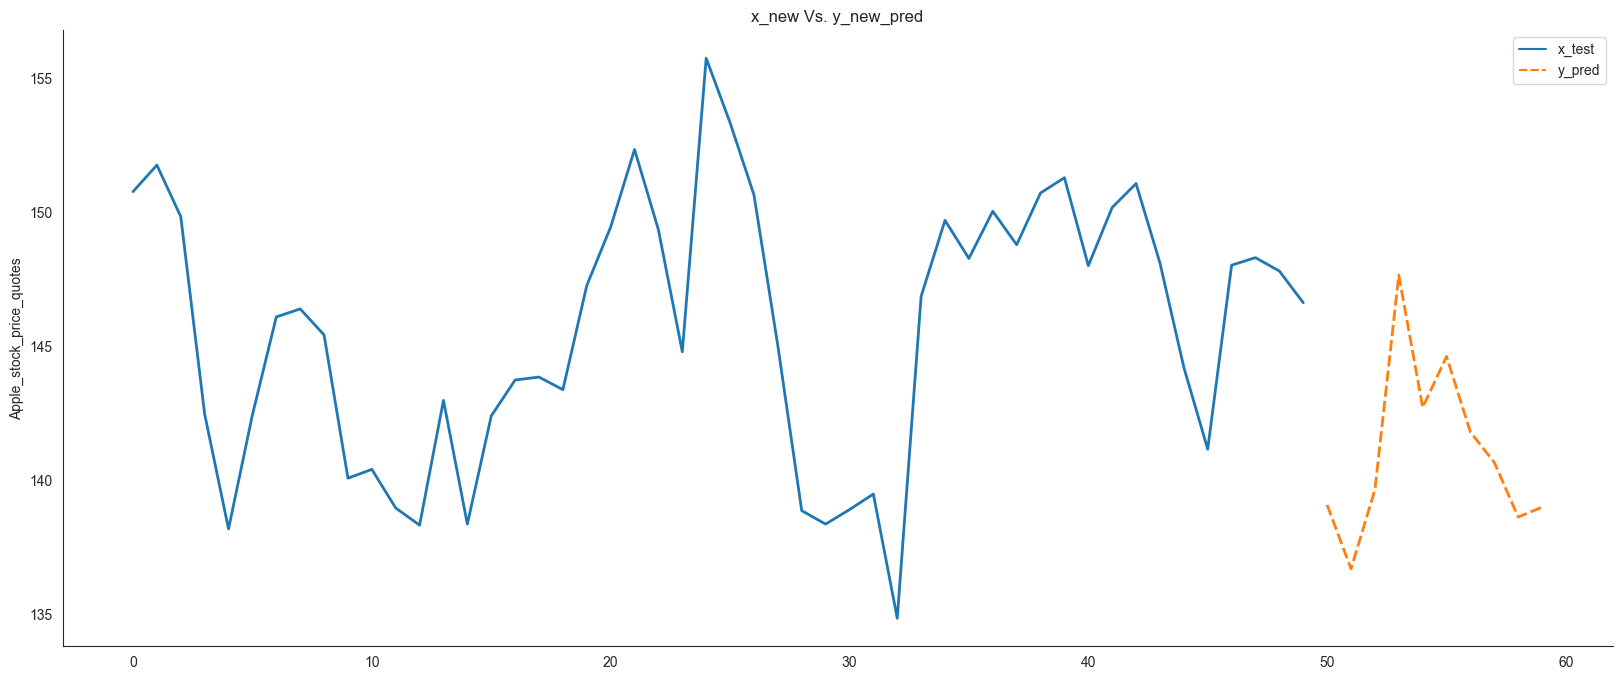

In [25]:
# Get the latest input batch from the test dataset, which is contains the price values for the last ten trading days
x_test_latest_batch = np_scaled[-50:,:].reshape(1,50,5)

# Predict on the batch
y_pred_scaled = model.predict(x_test_latest_batch)
y_pred_unscaled = scaler_pred.inverse_transform(y_pred_scaled)

# Prepare the data and plot the input data and the predictions
x_test_unscaled_df, y_test_unscaled_df, _ = prepare_df(0, x_test_latest_batch, '', y_pred_unscaled)
plot_multi_test_forecast(x_test_unscaled_df, '', y_test_unscaled_df, "x_new Vs. y_new_pred")